# Manual PreProcessing (Lower Case All)

In [2]:
#make all lowercase
def lower_df_text(df, text_columns):
    for column in text_columns:
        df[column] = df[column].apply(lambda x: x.lower())
    return

# Generating Wordclouds

In [122]:
from wordcloud import WordCloud
def plot_wordcloud(text, figname='wordcloud', rgb=(0,0,0), stop_words=[]):
    '''
    Takes a string and plots the x most common words. 
    Set color by changing rgb parameter
    Font path may vary, if error use font_path=None
    
    '''
    font_path = "/Library/Fonts/DIN Condensed Bold.ttf"
    wc = WordCloud(background_color="white",max_words=25,
                   collocations=False, font_path=font_path, scale=5,stopwords=stop_words, color_func=lambda *args, **kwargs: rgb)
    wc.generate(text)
    
    fig, ax = plt.subplots(figsize=(14,18))
    plt.imshow(wc)
    plt.savefig('data/wordclouds/{}'.format(figname), dpi=240)


# Generating Network Graphs


In [4]:
import networkx as nx
from networkx.algorithms import community

In [5]:
# Functionize

def generate_graph(edge_filepath, node_filepath, title='gephi_graph'):
    edges = pd.read_csv(edge_filepath, header=None)
    nodes = pd.read_csv(node_filepath, header=None)
    edges.columns = ['Source', 'Target']
    nodes.columns = ['Node', 'Alias']
    nodes = nodes.astype('str')
    edges = edges.astype('str')
    edge_tuples = []
    for source, target in zip(edges['Source'], edges['Target']):
        edge_tuples.append((source, target))
    G = nx.DiGraph()
    G.add_nodes_from(nodes['Node'])
    G.add_edges_from(edge_tuples)
    print(nx.info(G))
    nx.write_gexf(G, edge_filepath.append('{}'.format(title)))
    

# Text Processing Pipeline (Too Slow)
from https://www.kaggle.com/balatmak/text-preprocessing-steps-and-universal-pipeline#Reusable-pipeline

In [6]:
import numpy as np
import multiprocessing as mp

import string
import spacy 
import en_core_web_sm
from nltk.tokenize import word_tokenize
from sklearn.base import TransformerMixin, BaseEstimator
from normalise import normalise

nlp = en_core_web_sm.load()


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 variety="BrE",
                 user_abbrevs={},
                 n_jobs=1, custom_stop_words=[]):
        """
        Text preprocessing transformer includes steps:
            1. Text normalization
            2. Punctuation removal
            3. Stop words removal
            4. Lemmatization
        
        variety - format of date (AmE - american type, BrE - british format) 
        user_abbrevs - dict of user abbreviations mappings (from normalise package)
        n_jobs - parallel jobs to run
        """
        self.variety = variety
        self.user_abbrevs = user_abbrevs
        self.n_jobs = n_jobs
        self.custom_stop_words=custom_stop_words

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        normalized_text = self._normalize(text)
        doc = nlp(normalized_text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

    def _normalize(self, text):
        # some issues in normalise package
        try:
            return ' '.join(normalise(text, variety=self.variety, user_abbrevs=self.user_abbrevs, verbose=False))
        except:
            return text

    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in string.punctuation]

    def _remove_stop_words(self, doc):
        return [t for t in doc if t.is_stop != True and t.text not in self.custom_stop_words  and 'https' not in t.text]

    def _lemmatize(self, doc):
        return ' '.join([t.lemma_ for t in doc])

/Users/jacobmullins/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.semi_supervised.label_propagation module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.semi_supervised. Anything that cannot be imported from sklearn.semi_supervised is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/jacobmullins/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelPropagation from version 0.18 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Democratic Convention Data


#### 1.) Load df with processed text and descriptions

In [228]:
dconvention_df = pd.read_csv('large_data/dconvention_df.csv', index_col=0)
dconvention_df['user_description'].fillna('', inplace=True)
# nodes = 15,737
# edges = 88,537
# tweets = 134,687
# total users = 41,000

#### 2.) Load labeled community df

In [229]:
#top 5 democraty communities from gephi:
#18
#29
#70
#25
#46
#open labeled community nodes
dcommunity_df = pd.read_csv('large_data/communities_dconvention.csv', index_col='Id')
dcommunity_df.drop(columns=['timeset'], inplace=True)
dcommunity_df.drop(columns=['Label'], inplace=True)
dcommunity_df

,modularity_class
Id,
187059363,29
17546958,29
551557346,18
25073877,29
1339835893,18
...,...
224810490,196
576520016,70
616692598,70


#### 3.) Load node df to link community labels to the user names. Then merge community labels onto tweet df

In [230]:
dnodes_df = pd.read_csv('data/democrat/convention_mentions/dmention-nodes.csv')
dnodes_df = dnodes_df.join(dcommunity_df, how='left', on='Id')
dconvention_df = dconvention_df.merge(dnodes_df, left_on='user_screen_name', right_on='Label', how='outer')
dconvention_df['modularity_class'].dropna()

7          70.0
8          70.0
9          70.0
10         70.0
11         70.0
          ...  
149169    196.0
149170    196.0
149171     70.0
149172     70.0
149173     18.0
Name: modularity_class, Length: 26108, dtype: float64

In [231]:
#filter out all rows that don't have an assigned modularity class.
#we're left with 11,447 tweets (not bad)
dconvention_df = dconvention_df[dconvention_df['modularity_class'].isna() == False]

In [232]:
#drop the unneeded columns
features = [
        'id', 'place', 'user_location',
       'favorite_count', 
        'retweet_count', 
       'text', 
       'user_screen_name', 'user_description',
       'user_followers_count', 
       'user_name', 
       'Id', 'modularity_class']


dconvention_df = dconvention_df[features]
dconvention_df = dconvention_df[dconvention_df['text'].isna()==False]
dconvention_df.rename(columns={'modularity_class':'community'},inplace=True)

In [233]:
# group by user id and sum their tweets.

combined_text = dconvention_df.groupby(['user_screen_name']).apply(lambda x: ' '.join(x['text']))
combined_text.rename('combined_text',inplace=True)
dconvention_df = dconvention_df.merge(combined_text, left_on='user_screen_name',right_index=True)

user_summary = dconvention_df.groupby(['user_screen_name', 'user_location','user_description', 'combined_text', 'community']).mean()
user_summary.drop(columns=['id', 'Id'], inplace=True)
user_summary.reset_index(inplace=True)

user_screen_name
1031ent            vote jillstein tired corrupt politics corrupt ...
10eBill            total fabrication herr trump politics question...
1199SEIU           `` america greatness measured many millionaire...
15JudicialCASA     story teller extraordinaire man want go fast g...
201Bar             coming next week tonight american whiskeys amp...
                                         ...                        
zahavrestaurant                                           big thanks
zdaniel            take look map rather interesting tv story last...
zebraonice         dems want circus tv think anymore corrupt keep...
ziibiing           finally flight join hoping get good nap native...
zschiffman                                 stage mgr pa representing
Name: combined_text, Length: 1238, dtype: object

#### 4.) Break top 5 communities into separate df and explore data

In [234]:
user_summary

,user_screen_name,user_location,user_description,combined_text,community,favorite_count,retweet_count,user_followers_count
0,1031ent,"Dallas, TX",vip entertainer ent tweeting magicianlifestyle,vote jillstein tired corrupt politics corrupt ...,2363.0,4.000000,0.333333,31438.666667
1,10eBill,United States,,total fabrication herr trump politics question...,1556.0,0.000000,0.000000,128.000000
2,1199SEIU,"New York, NY",mission win quality healthcare good jobs natio...,`` america greatness measured many millionaire...,18.0,4.562500,2.812500,17985.000000
3,15JudicialCASA,"CA.Bar, D.C. Bar retired to KC",keep love heart always life without sunless ga...,story teller extraordinaire man want go fast g...,25.0,0.416667,0.166667,1835.000000
4,201Bar,Capitol Hill - Washington DC,permanently closed,coming next week tonight american whiskeys amp...,1576.0,0.500000,0.000000,1153.000000
...,...,...,...,...,...,...,...,...
1115,zahavrestaurant,Philadelphia,ten years ’ calling zahav “ modern israeli res...,big thanks,219.0,3.000000,0.000000,11116.000000
1116,zdaniel,Melbourne Australia,reporter large|was us bureau chief|se asia afr...,take look map rather interesting tv story last...,70.0,1.333333,1.666667,29680.000000
1117,zebraonice,"Phoenix, AZ",incredible parallel parker best contestant pri...,dems want circus tv think anymore corrupt keep...,18.0,0.000000,0.000000,459.000000
1118,ziibiing,"San Antonio, TX",ajijaak nindoodem internet politics planet com...,finally flight join hoping get good nap native...,106.0,4.882353,1.372549,9502.000000


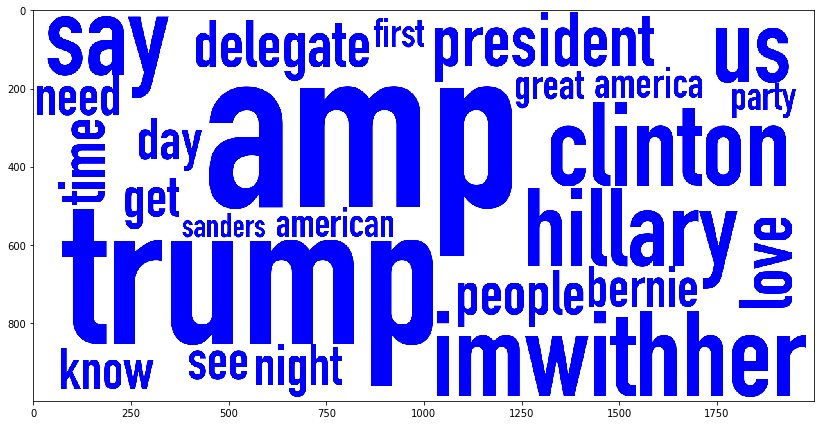

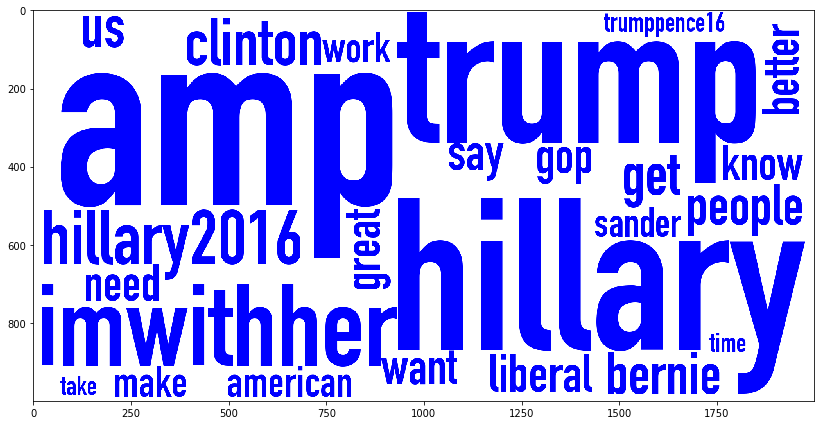

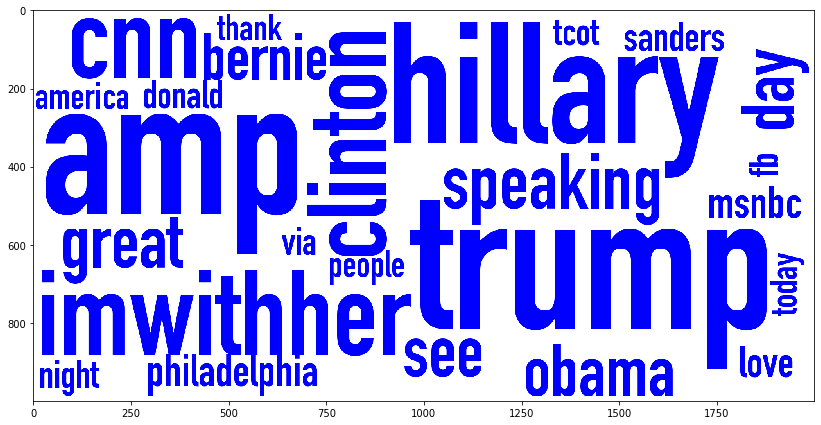

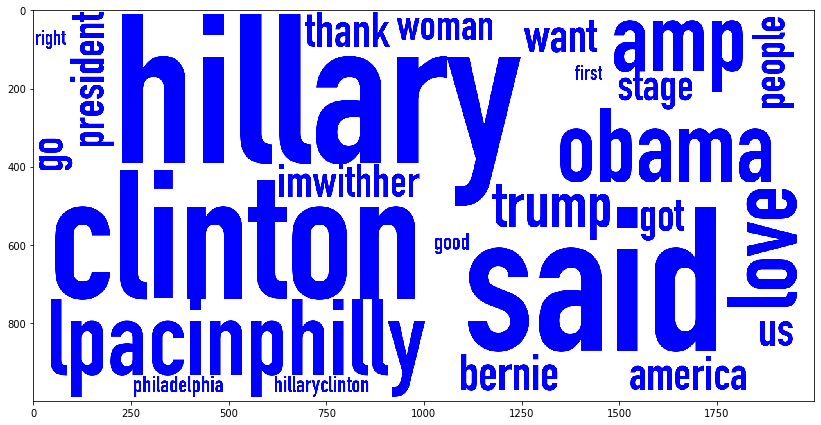

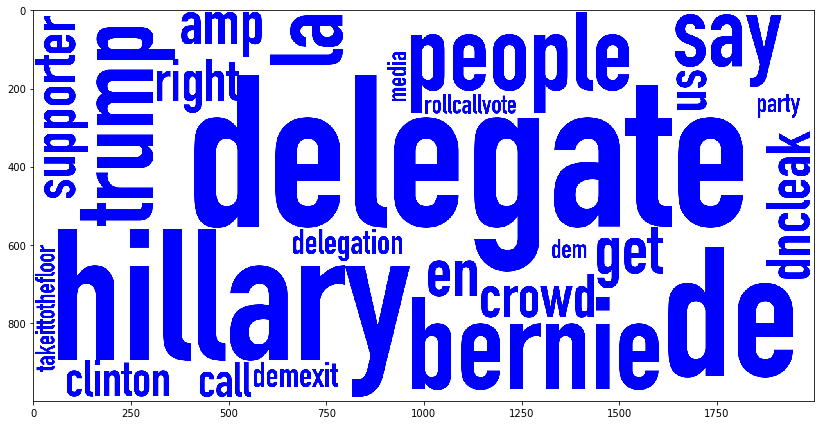

In [235]:
community18 = user_summary[user_summary['community']==18.0]
community29 = user_summary[user_summary['community']==29.0]
community70 = user_summary[user_summary['community']==70.0]
community25 = user_summary[user_summary['community']==25.0]
community46 = user_summary[user_summary['community']==46.0]

#plot text word clouds
plot_wordcloud((' '.join(community18['combined_text'])), rgb=(0,0,255), stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote'])
plot_wordcloud((' '.join(community29['combined_text'])), rgb=(0,0,255), stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote'])
plot_wordcloud((' '.join(community70['combined_text'])), rgb=(0,0,255), stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote'])
plot_wordcloud((' '.join(community25['combined_text'])), rgb=(0,0,255), stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote'])
plot_wordcloud((' '.join(community46['combined_text'])), rgb=(0,0,255), stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote'])

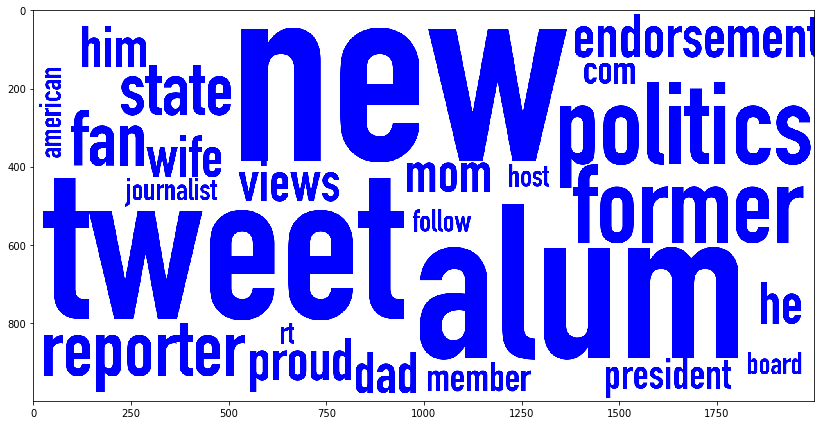

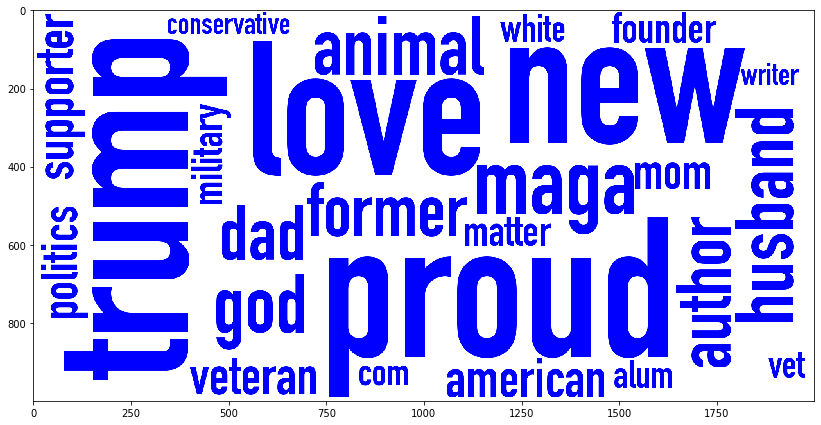

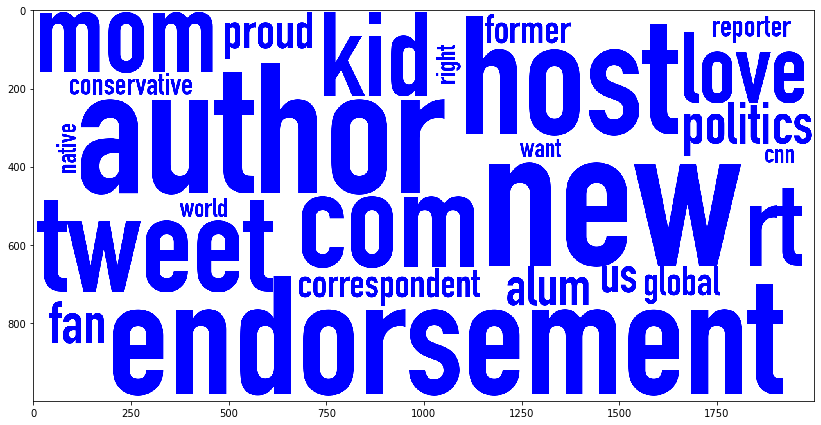

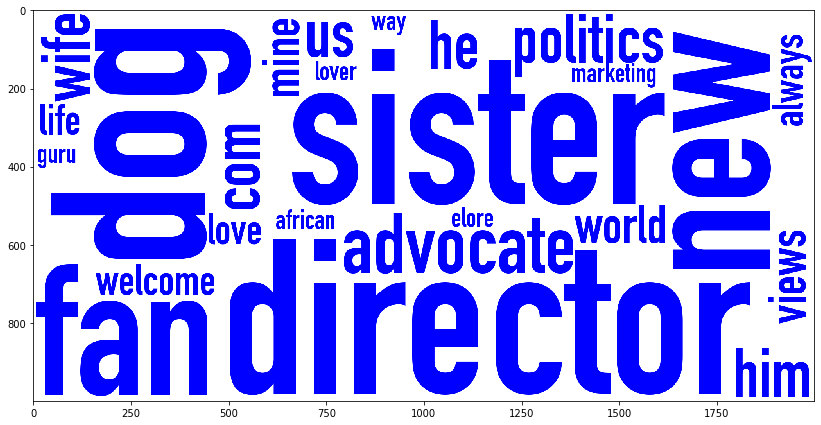

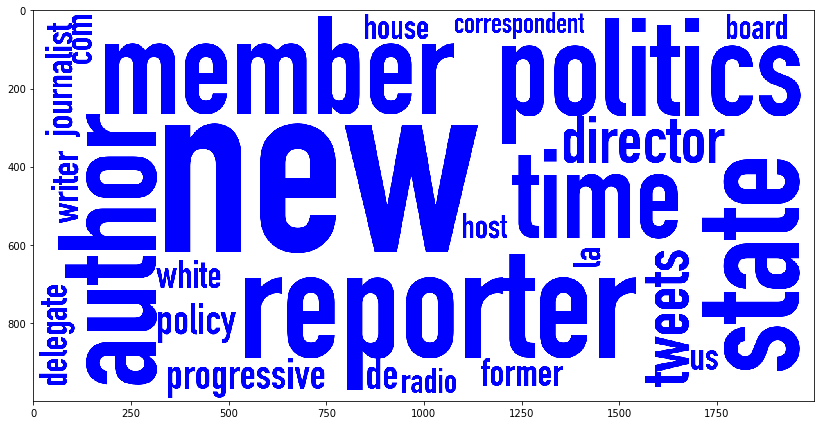

In [236]:
#plot user description word clouds

plot_wordcloud(' '.join(community18['user_description']), rgb=(0,0,255),stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote']) #educated political writes
plot_wordcloud(' '.join(community29['user_description']), rgb=(0,0,255),stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote']) #convsrvatives/patriots
plot_wordcloud(' '.join(community70['user_description']), rgb=(0,0,255),stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote']) #conservative professionals/writers
plot_wordcloud(' '.join(community25['user_description']), rgb=(0,0,255),stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote']) #liberals
plot_wordcloud(' '.join(community46['user_description']), rgb=(0,0,255),stop_words=['demconvention', 'democratic', 'debate', 'dncinphl', 'convention', 'tonight', 'vote']) #professional liberal women

In [237]:
#18
#29
#70
#25
#46
users = community18.append(community29).append(community70).append(community25).append(community46)
users

,user_screen_name,user_location,user_description,combined_text,community,favorite_count,retweet_count,user_followers_count
2,1199SEIU,"New York, NY",mission win quality healthcare good jobs natio...,`` america greatness measured many millionaire...,18.0,4.562500,2.812500,17985.0
6,270Strategies,DC - Chicago,helping organizations build modern people-cent...,course ’ always work thankfully spectacular vi...,18.0,8.285714,0.428571,8824.0
16,ACPressHuba,"Pleasantville, NJ",sports/news/digital editor grad father golf na...,front page today featuring stories sounds fun ...,18.0,0.428571,0.285714,3170.0
18,AFP,France,top news features afp reporters around world e...,fbi probes email hack russia blame breaking be...,18.0,33.000000,48.000000,1862910.0
25,AUCDNews,"Silver Spring, MD",aucd advances policies practices people develo...,"delegates w disabilities dncinphl,30+ mentions...",18.0,0.000000,3.000000,12849.0
...,...,...,...,...,...,...,...,...
1016,rushdia_zareen,"Massachusetts, USA",care justice,great parents wish could raise two boys,46.0,1.000000,0.000000,280.0
1045,stephroyal,Jerzee 201,call chitadori shut spot spittin flame got all...,tuesdaymotivation threewordstosay america need...,46.0,2.000000,1.500000,1813.0
1056,talk1073,"Baton Rouge, Louisiana",baton rouge ’ “ new flavor ” mornings brian ha...,billy tauzin comments woman presidential ticke...,46.0,0.100000,0.100000,4265.0
1076,timoshei,New York,writer speaker enterprise reporter children ’ ...,jillnothill common refrain outside amp rncincl...,46.0,0.000000,0.000000,2991.0


#### 5.) Vectorize / TFIDF

In [248]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB

vectorizer = TfidfVectorizer()

X = users['user_description'] + users['combined_text']
y = users['community']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [249]:
#logistic model
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)
print('Logistic Regression Model Score: {}'.format(lr_score))

#random forest
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
print('Random Forest Model Score: {}'.format(rf_score))

#stochastic gradient descent
sgd = SGDClassifier(class_weight='balanced')
sgd.fit(X_train, y_train)
sgd_score = sgd.score(X_test, y_test)
print('SGD Model Score: {}'.format(sgd_score))

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Logistic Regression Model Score: 0.4866666666666667


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Random Forest Model Score: 0.4533333333333333


SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

SGD Model Score: 0.47333333333333333


#### Try to get the top features for each community

In [240]:
features_names = vectorizer.get_feature_names()

,feature,tfidf
0,que,0.385313
1,change,0.203591
2,putin,0.200606
3,heart,0.188027
4,old,0.170011
5,color,0.159391
6,nice,0.144338
7,girl,0.143489
8,tom,0.142655
9,washington,0.141837


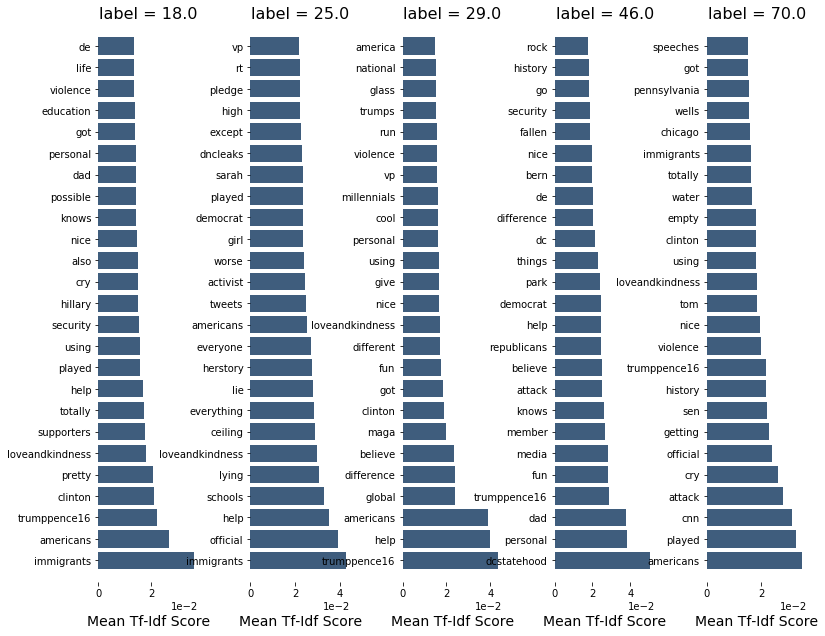

In [241]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

top_feats_in_doc(X_train,feature_names,2)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs
dfs=top_feats_by_class(X_train,y_train,feature_names)

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()
    
plot_tfidf_classfeats_h(dfs)

#### Create a new feature "influence" which is a sum of user followers + total retweets + likes

In [213]:
community18.sort_values(by='user_followers_count', ascending=False).head() # hispanic and minotity communities
community29.sort_values(by='user_followers_count', ascending=False).head() # conservative
community70.sort_values(by='user_followers_count', ascending=False).head() # journalists
community25.sort_values(by='user_followers_count', ascending=False).head() # women / womens rights advocates
community46.sort_values(by='user_followers_count', ascending=False).head() # activists and political outsiders / bernie supporters

,user_screen_name,user_location,user_description,combined_text,community,favorite_count,retweet_count,user_followers_count
299,KamalaHarris,California,u.s. senator wife momala auntie still fighting...,`` best darn changemaker 've ever met entire l...,18.0,113.750000,34.500000,3.625186e+06
18,AFP,France,top news features afp reporters around world e...,fbi probes democratic email hack russia blame ...,18.0,33.000000,48.000000,1.862910e+06
338,LeonKrauze,"Los Angeles, CA",journo column podcast epicentro written lkrauz...,es una buena noticia para los demócratas que l...,18.0,13.230769,7.153846,1.450041e+06
90,CDN37,República Dominicana,cdn el canal de noticias de los dominicanos no...,`` juntos somos más fuertes '' `` hace años ha...,18.0,1.000000,0.500000,9.769875e+05
576,TelemundoNews,United States,noticias del de nuestra comunidad lascosascomoson,`` president respect men women risk lives serv...,18.0,4.250000,3.388889,7.798860e+05


,user_screen_name,user_location,user_description,combined_text,community,favorite_count,retweet_count,user_followers_count
347,LouDobbs,"New York, NY",lou dobbs tonight fox business network pm eastern,ldtpoll get bigger bounce convention trump rnc...,29.0,482.333333,401.333333,2.159600e+06
151,DineshDSouza,United States,behind modern-day socialism evil stop `` unite...,'m live show hour tune hear us talk dnc check ...,29.0,161.500000,68.000000,1.508246e+06
698,brithume,Southwest Florida,sr. political analyst fox news channel argumen...,hear hear pleased great guy sunday night phila...,29.0,256.500000,42.500000,1.200711e+06
661,anamariecox,"Minneapolis, MN",one ever made world better perfect she/her out...,`` look serious '' dncinphilly democratic nati...,29.0,11.117647,2.705882,1.196426e+06
1112,wsbtv,"Atlanta, GA",metro atlanta 1 source breaking news weather t...,spotted snapchatting dncinphl find us behind-t...,29.0,12.000000,0.000000,1.181500e+06


,user_screen_name,user_location,user_description,combined_text,community,favorite_count,retweet_count,user_followers_count
284,JoyAnnReid,USA,`` must bold brave courageous find way ... get...,wow week moms mothers movement orlando mom cou...,70.0,453.592593,180.407407,1.630939e+06
766,druidDUDE,Los Angeles,former boston celtic,guys guys guys dnc love arts … dnc ready excit...,70.0,261.500000,48.000000,1.306528e+06
760,donlemon,NYC,cnn anchor twitter king ... .. follow instagram,katyperry cnngrill cnn katyperry cnngrill cnn ...,70.0,245.333333,33.000000,1.017075e+06
92,CNNgo,Everywhere,cnn fingertips watch want want,talks future `` bernie bust '' movement,70.0,7.000000,2.000000,6.869870e+05
826,howardfineman,"Washington, DC",news analyst contributing correspondent author...,dnc stop convention center pm q amp 'm connieb...,70.0,103.571429,30.571429,2.434110e+05


,user_screen_name,user_location,user_description,combined_text,community,favorite_count,retweet_count,user_followers_count
469,PhaedraParks,Worldwide,super sassy always classy attorney stars-south...,imwithher philadelphia dnc2016 hillaryclinton ...,25.0,70.000000,7.000000,967674.000000
421,NancyLeeGrahn,A blue state,act tv citizen opinions absolving anyone else ...,woman friend educated committed latino list ac...,25.0,385.333333,57.666667,146578.666667
169,EdwardGLuce,Washington DC,associate editor financial times us-based writ...,sixth nth big jamboree philly far chaotic,25.0,2.000000,2.000000,75222.000000
657,amandahite,"Washington, DC",cofounder ceo 442 inc. ’ keynote speaker advoc...,official hillyeah demconvention lpacinphilly b...,25.0,5.500000,1.500000,41463.941176
1073,thephillyvoice,Philadelphia,looking beyond simple headlines tells stories ...,sanders urges fans rally behind clinton dnc201...,25.0,2.363636,2.090909,40447.000000


,user_screen_name,user_location,user_description,combined_text,community,favorite_count,retweet_count,user_followers_count
60,BernieSanders,Vermont,u.s. senator vermont candidate president unite...,thank delegates representing revolution philad...,46.0,9988.000000,2217.000000,11942559.0
217,GrantCardone,"Miami, FL",real estate investor 1.7b aum founder x moveme...,upset bradley cooper attended dnc need bigger ...,46.0,19.000000,4.000000,428219.0
980,ninaturner,"Cleveland, OH",blessed god wife mother sister national co-cha...,rep. marcia fudge named permanent chair democr...,46.0,512.666667,224.333333,344848.0
1087,tonydandrades,Miami,posts mine alone necessarily reflect opinions ...,que bien,46.0,7.000000,0.000000,249764.0
464,People4Bernie,United States,activists organizers building broad effective ...,`` takes great courage stand enemies takes eve...,46.0,133.022727,79.590909,234123.0


# Democratic Candidates Data

# Republican Candidates Data